In [1]:
import pandas as pd

chemin_fichier_partie_rapide = 'archive/ow2_quickplay_heroes_stats__2023-05-06.csv'
chemin_fichier_saison_1 = 'archive/ow2_season_01_FINAL_heroes_stats__2023-05-06.csv' 
chemin_fichier_saison_2 = 'archive/ow2_season_02_FINAL_heroes_stats__2023-05-06.csv'
chemin_fichier_saison_3 = 'archive/ow2_season_03_FINAL_heroes_stats__2023-05-06.csv'
chemin_fichier_saison_4 = 'archive/ow2_season_04_FINAL_heroes_stats__2023-05-06.csv'

chemin_up_et_nerf = 'archive/Up_Nerf.csv'

def WinRate_PickRate():
    df = pd.read_csv(chemin_fichier_partie_rapide)

    selection_victoire = df[['Hero', 'Skill Tier', 'Pick Rate, %', 'Win Rate, %']]

    moyennes_selection_victoire = selection_victoire.groupby(['Hero', 'Skill Tier']).mean().reset_index()

    moyennes_selection_victoire.to_json('WinRate_PickRate.json', orient='records', indent=4)

    print(moyennes_selection_victoire)

def meilleur_composition_par_saison(chemin_fichier):
    df = pd.read_csv(chemin_fichier)

    df = df.loc[df['Skill Tier'] == 'Grandmaster']

    selection_victoire = df[['Hero', 'Role', 'Pick Rate, %']]

    meilleur_tank = selection_victoire[selection_victoire['Role'] == 'Tank'].nlargest(1, 'Pick Rate, %')
    meilleur_dps = selection_victoire[selection_victoire['Role'] == 'Damage'].nlargest(2, 'Pick Rate, %')
    meilleur_supp = selection_victoire[selection_victoire['Role'] == 'Support'].nlargest(2, 'Pick Rate, %')

    best_comp = pd.concat([meilleur_tank, meilleur_supp, meilleur_dps])

    return best_comp

def Comp_selon_saison():
    for i in range(1, 5):
        chemin_fichier = f'archive/ow2_season_0{i}_FINAL_heroes_stats__2023-05-06.csv'
        best_comp = meilleur_composition_par_saison(chemin_fichier)

        best_comp.to_json(f'Best_Comp_Saison_{i}.json', orient='records', indent=4)

def kda_global_per_champion():
    print("Calcul du KDA global par champion et par rang...")
    files = [f'archive/ow2_season_0{i}_FINAL_heroes_stats__2023-05-06.csv' for i in range(1, 5)]
    all_data = []

    for file_path in files:
        df = pd.read_csv(file_path)
        if 'Eliminations / 10min' in df.columns and 'Deaths / 10min' in df.columns:
            df['Season'] = file_path.split('_')[2]
            all_data.append(df[['Hero', 'Skill Tier', 'Season', 'Eliminations / 10min', 'Deaths / 10min']])

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df['KDA'] = combined_df['Eliminations / 10min'] / combined_df['Deaths / 10min']
        kda_selection = combined_df[['Hero', 'Skill Tier', 'KDA']].groupby(['Hero', 'Skill Tier']).mean().reset_index()
        kda_selection.to_json('KDA_Global.json', orient='records', indent=4)
        print("Le fichier KDA_Global.json a été créé avec succès.")
    else:
        print("Aucune donnée n'a été trouvée pour calculer le KDA.")
        
def create_headshot_accuracy_json():
    files = [f'archive/ow2_season_0{i}_FINAL_heroes_stats__2023-05-06.csv' for i in range(1, 5)]

    all_data = []

    for file in files:
        df = pd.read_csv(file)
        if 'Crit Accuracy, %' in df.columns:
            df_filtered = df[['Hero', 'Skill Tier', 'Crit Accuracy, %']]
            all_data.append(df_filtered)
        else:
            print(f"Column 'Headshot Accuracy, %' not found in {file}")

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        combined_df.to_json('Headshot_Accuracy.json', orient='records', indent=4)
        print("Le fichier Headshot_Accuracy.json a été créé avec succès.")
    else:
        print("Aucune donnée d'accuracy de headshot trouvée dans les fichiers.")

def Impact_Up_Nerf():
    # Liste pour stocker les DataFrames de chaque saison
    dataframes = []
    
    # Charger les données de chaque saison dans une liste de DataFrames
    for i in range(1, 5):
        chemin_fichier = f'archive/ow2_season_0{i}_FINAL_heroes_stats__2023-05-06.csv'
        df = pd.read_csv(chemin_fichier)
        df['Saison'] = f'Saison {i}'  # Ajouter une colonne pour identifier la saison
        dataframes.append(df)
    
    saison_df = pd.concat(dataframes, ignore_index=True)
    
    Up_et_Nerf_df = pd.read_csv('archive/Up_Nerf.csv')
    Up_et_Nerf_df_long = pd.melt(Up_et_Nerf_df, id_vars=['Hero'], var_name='Saison', value_name='Equilibrage')
    Up_et_Nerf_df_long['Equilibrage'] = Up_et_Nerf_df_long['Equilibrage'].fillna('Null')
    Up_et_Nerf_df_long['Saison'] = Up_et_Nerf_df_long['Saison'].str.replace('Saison ', 'Saison ')
    
    fusion_df = saison_df.merge(Up_et_Nerf_df_long, on=['Hero', 'Saison'], how='left')
    impact_df = fusion_df.groupby(['Hero', 'Role', 'Saison', 'Equilibrage'])[['Pick Rate, %', 'Win Rate, %']].mean().reset_index()
    
    impact_df.to_json('impact_equilibrage.json', orient='records', indent=4)

def champion_stats_per_tier():
    print("Calcul des statistiques des champions par rang...")

    # Définir les chemins des fichiers pour chaque saison
    files = [f'archive/ow2_season_0{i}_FINAL_heroes_stats__2023-05-06.csv' for i in range(1, 5)]
    all_data = []

    for file_path in files:
        df = pd.read_csv(file_path)
        # Vérifier si les colonnes nécessaires sont présentes
        if 'Hero' in df.columns and 'Skill Tier' in df.columns \
                and 'Eliminations / 10min' in df.columns:
            # Nettoyer les données pour supprimer les lignes avec des valeurs manquantes
            df_cleaned = df.dropna(subset=['Hero', 'Skill Tier', 'Eliminations / 10min'])
            # Sélectionner uniquement les colonnes nécessaires
            df_selected = df_cleaned[['Hero', 'Skill Tier', 'Eliminations / 10min']]
            # Vérifier si la colonne de guérison est disponible avant de l'ajouter
            if 'Healing / 10min' in df.columns:
                df_selected['Healing / 10min'] = df_cleaned['Healing / 10min']
            else:
                df_selected['Healing / 10min'] = None
            all_data.append(df_selected)

    if all_data:
        # Concaténer tous les DataFrames en un seul DataFrame
        combined_df = pd.concat(all_data)
        # Réorganiser les colonnes pour avoir la colonne de guérison avant celle des éliminations
        combined_df = combined_df[['Hero', 'Skill Tier', 'Healing / 10min', 'Eliminations / 10min']]
        # Enregistrer les données dans un fichier JSON
        combined_df.to_json('Champion_Stats_Per_Tier.json', orient='records', indent=4)

In [ ]:
Comp_selon_saison()

In [12]:
WinRate_PickRate()

         Hero   Skill Tier  Pick Rate, %  Win Rate, %
0         Ana          All          7.75        48.73
1         Ana       Bronze          6.05        47.17
2         Ana      Diamond          7.91        48.29
3         Ana         Gold          6.01        47.54
4         Ana  Grandmaster          8.39        48.26
..        ...          ...           ...          ...
283  Zenyatta         Gold          2.96        52.20
284  Zenyatta  Grandmaster          3.90        52.39
285  Zenyatta       Master          3.91        52.46
286  Zenyatta     Platinum          3.35        52.18
287  Zenyatta       Silver          2.96        51.90

[288 rows x 4 columns]


In [13]:
kda_global_per_champion()

Calcul du KDA global par champion et par rang...
Le fichier KDA_Global.json a été créé avec succès.


In [14]:
create_headshot_accuracy_json()

Le fichier Headshot_Accuracy.json a été créé avec succès.


In [15]:
Impact_Up_Nerf()

In [ ]:
champion_stats_per_tier()

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def Graph_WinRate_PickRate():
    win_rate_par_rank_par_champ = pd.read_json('WinRate_PickRate.json')

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Pick Rate, %', y='Hero', hue='Skill Tier', data=win_rate_par_rank_par_champ)
    plt.title('Taux de sélection par Héros et par Rank')
    plt.legend(title='Skill Tier')
    plt.show()

    plt.figure(figsize=(14, 10))
    sns.barplot(x='Win Rate, %', y='Hero', hue='Skill Tier', data=win_rate_par_rank_par_champ)
    plt.title('Taux de victoire par Héros et par Rank')
    plt.legend(title='Skill Tier')
    plt.show()

def Comp_selon_saison():
    data_list = []
    
    for i in range(1, 5):
        chemin_fichier = f'Best_Comp_Saison_{i}.json' 
        best_comp = pd.read_json(chemin_fichier)
        data_list.append(best_comp)
    
    for i, best_comp in enumerate(data_list, start=1):
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Hero', y='Pick Rate, %', hue='Role', data=best_comp)
        plt.title(f'Meilleure Composition Saison {i} (Grandmaster)')
        plt.xlabel('Héros')
        plt.ylabel('Taux de Sélection (%)')
        plt.xticks(rotation=45)
        plt.legend(title='Rôle')
        plt.tight_layout()
        plt.show()

def Graph_KDA_par_champion():
    data_list = []
    
    chemin_fichier = f'KDA_Global.json'  
    kda_data = pd.read_json(chemin_fichier)
    data_list.append(kda_data)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='KDA', y='Hero', hue='Skill Tier', data=kda_data)
    plt.title(f'KDA par Champion')
    plt.xlabel('KDA')
    plt.ylabel('Héros')
    plt.xticks(rotation=45)
    plt.legend(title='Skill Tier')
    plt.tight_layout()
    plt.show()
    
    
def Graph_Headshot_Accuracy():
    chemin_fichier = 'Headshot_Accuracy.json'
    headshot_data = pd.read_json(chemin_fichier)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Crit Accuracy, %', y='Hero', hue='Skill Tier', data=headshot_data)
    plt.title('Accuracy des Headshots par Champion et par Rank')
    plt.xlabel('Accuracy des Headshots (%)')
    plt.ylabel('Héros')
    plt.xticks(rotation=45)
    plt.legend(title='Skill Tier')
    plt.tight_layout()
    plt.show()

def Graph_Headshot_Accuracy_By_Tier():
    chemin_fichier = 'Headshot_Accuracy.json'
    headshot_data = pd.read_json(chemin_fichier)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Skill Tier', y='Crit Accuracy, %', data=headshot_data)
    plt.title('Accuracy des Headshots par Rank')
    plt.xlabel('Skill Tier')
    plt.ylabel('Accuracy des Headshots (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def Graph_Best_Healers():
    # Charger les données à partir du fichier JSON
    best_healers_data = pd.read_json('Champion_Stats_Per_Tier.json')

    # Créer le graphique
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Healing / 10min', y='Hero', data=best_healers_data)
    plt.title('Meilleurs guérisseurs par guérison en 10min')
    plt.xlabel('Guérison en 10min')
    plt.ylabel('Héros')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def Graph_Best_Eliminators():
    # Charger les données à partir du fichier JSON
    best_eliminations_data = pd.read_json('Champion_Stats_Per_Tier.json')

    # Créer le graphique
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Eliminations / 10min', y='Hero', data=best_eliminations_data)
    plt.title('Meilleurs éliminateurs par éliminations en 10min')
    plt.xlabel('Éliminations en 10min')
    plt.ylabel('Héros')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

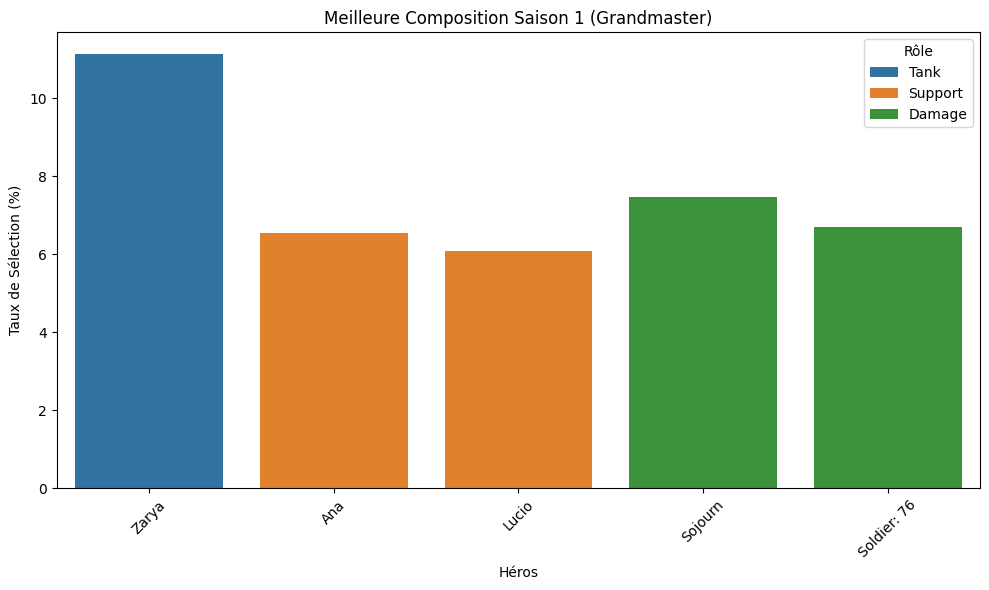

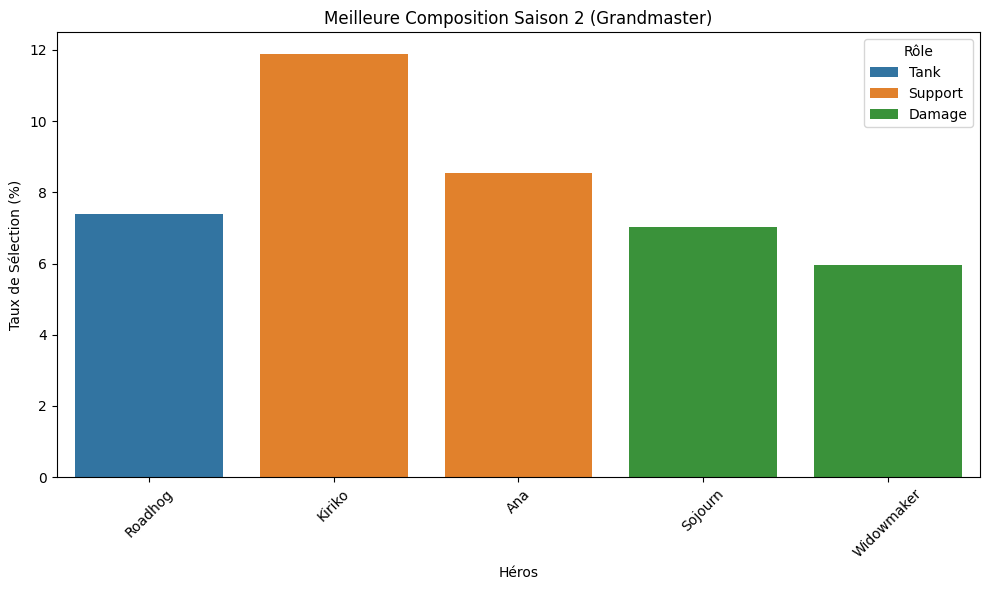

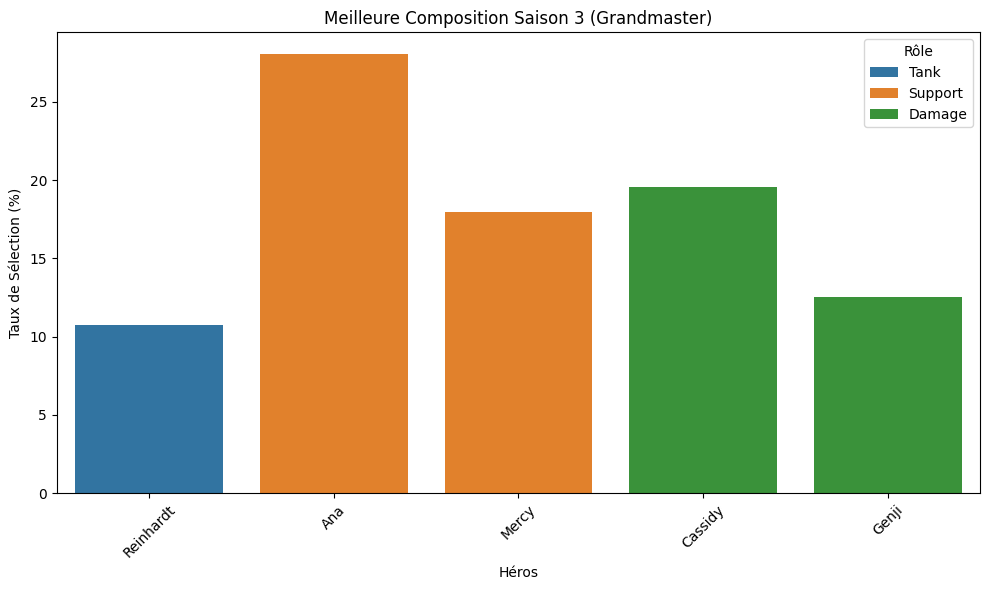

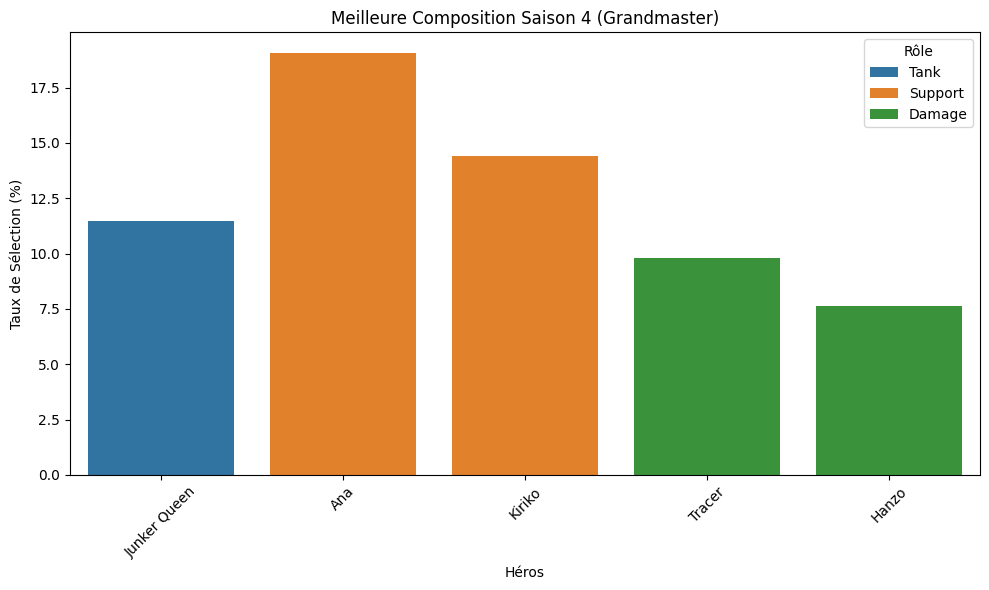

In [4]:
Comp_selon_saison()

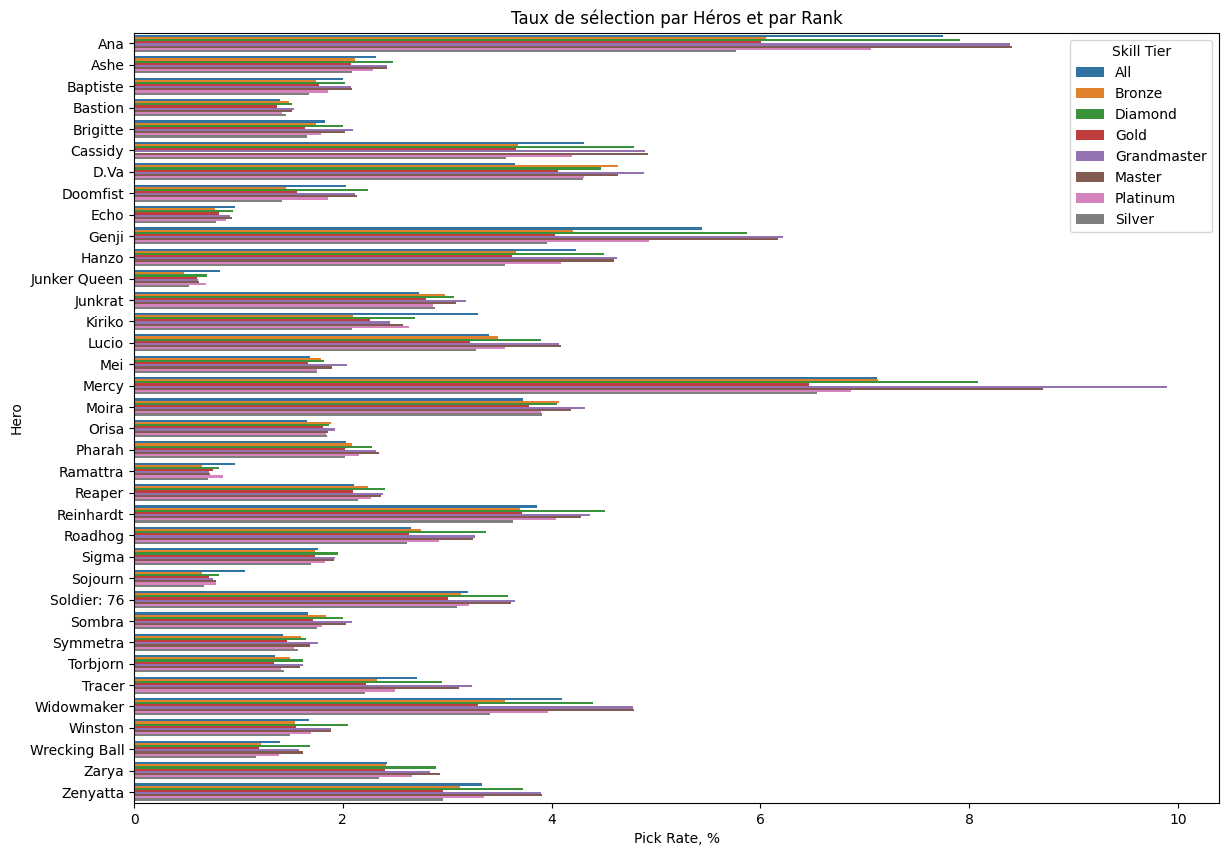

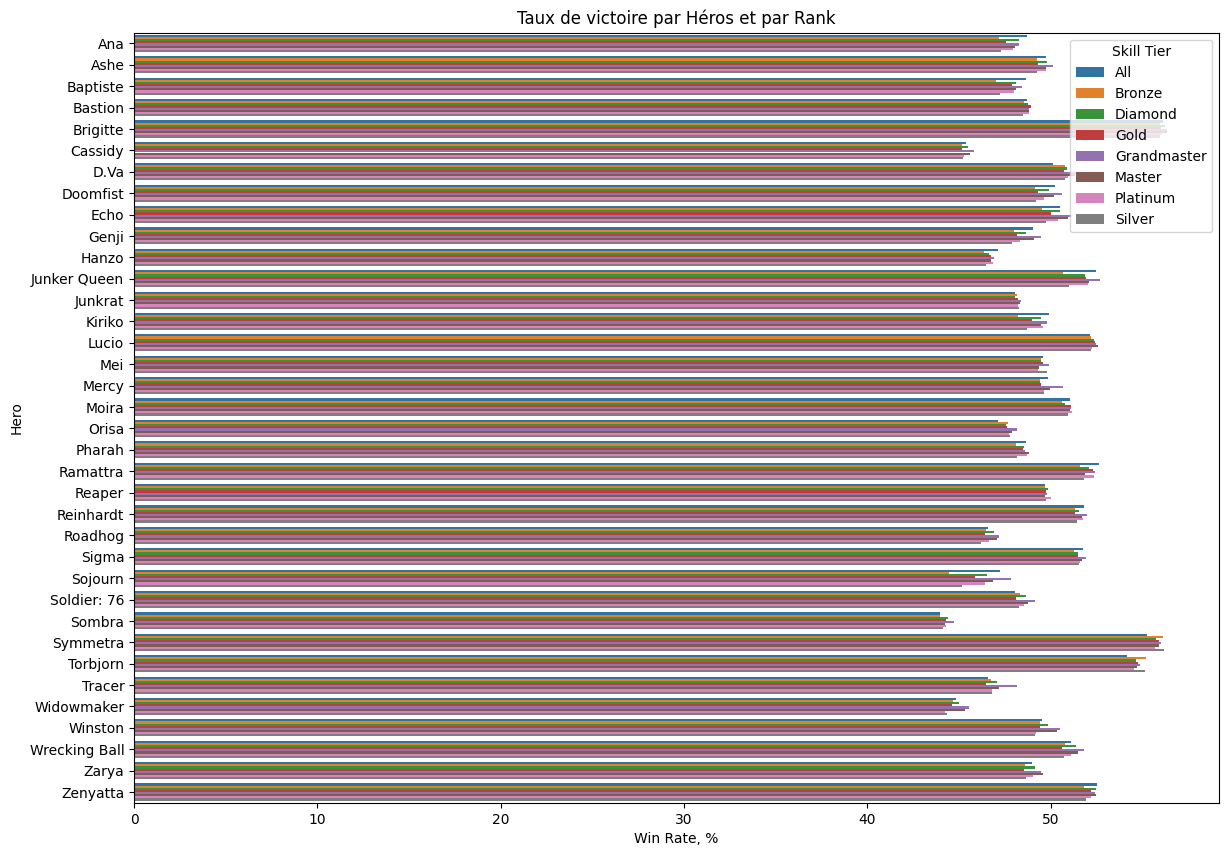

In [5]:
Graph_WinRate_PickRate()

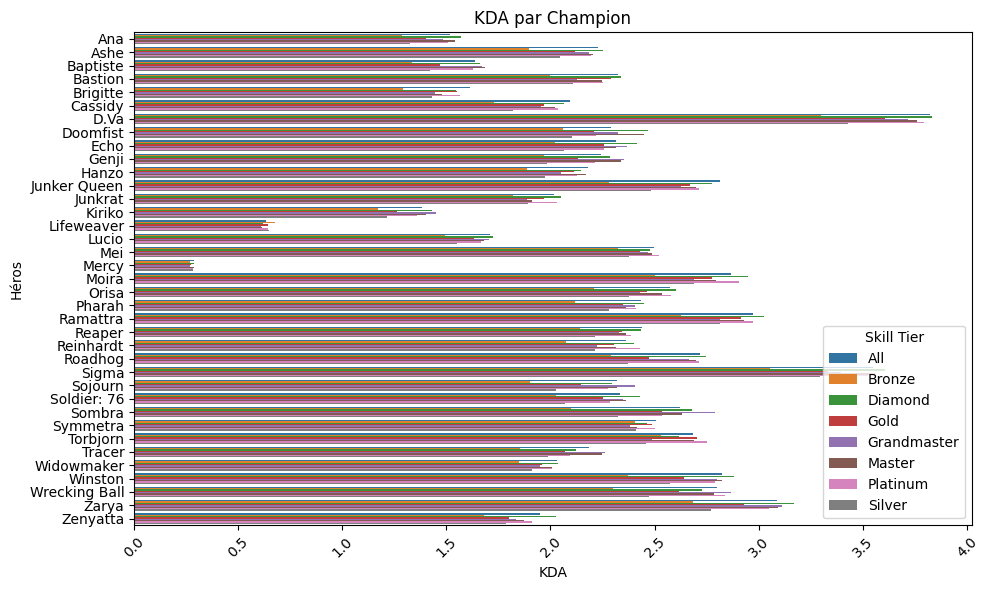

In [6]:
Graph_KDA_par_champion()

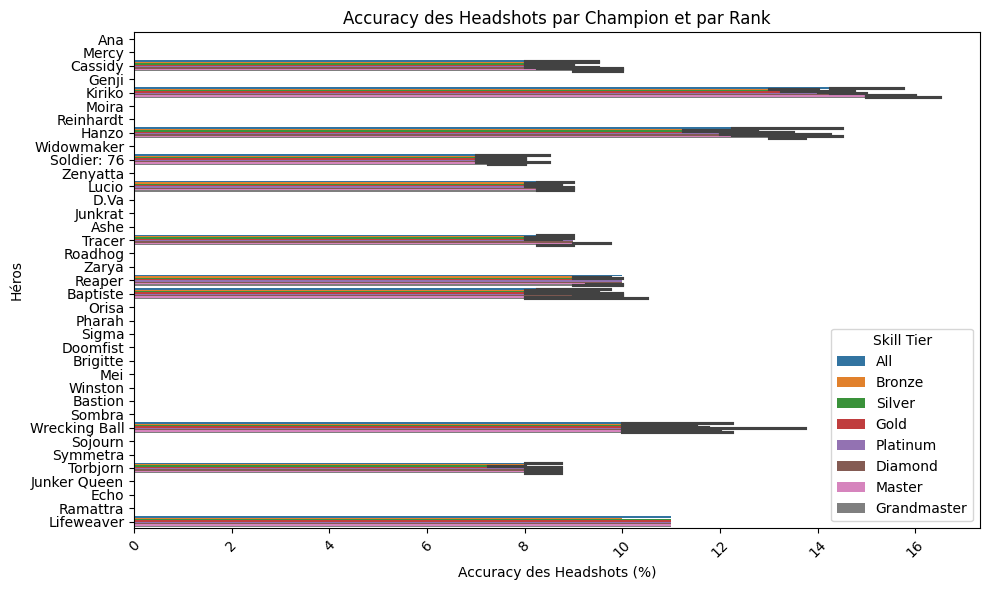

In [7]:
Graph_Headshot_Accuracy()

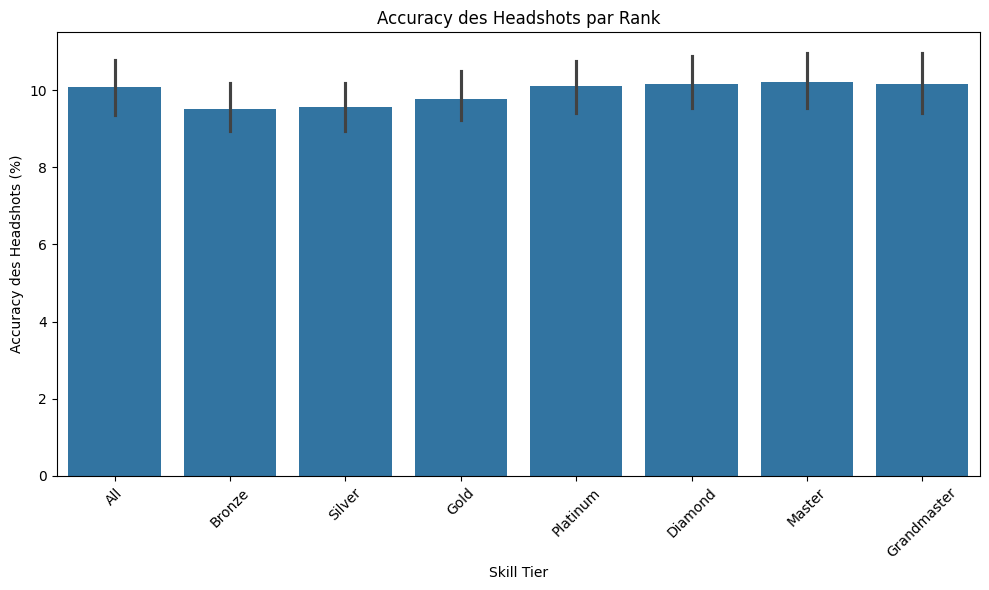

In [8]:
Graph_Headshot_Accuracy_By_Tier()

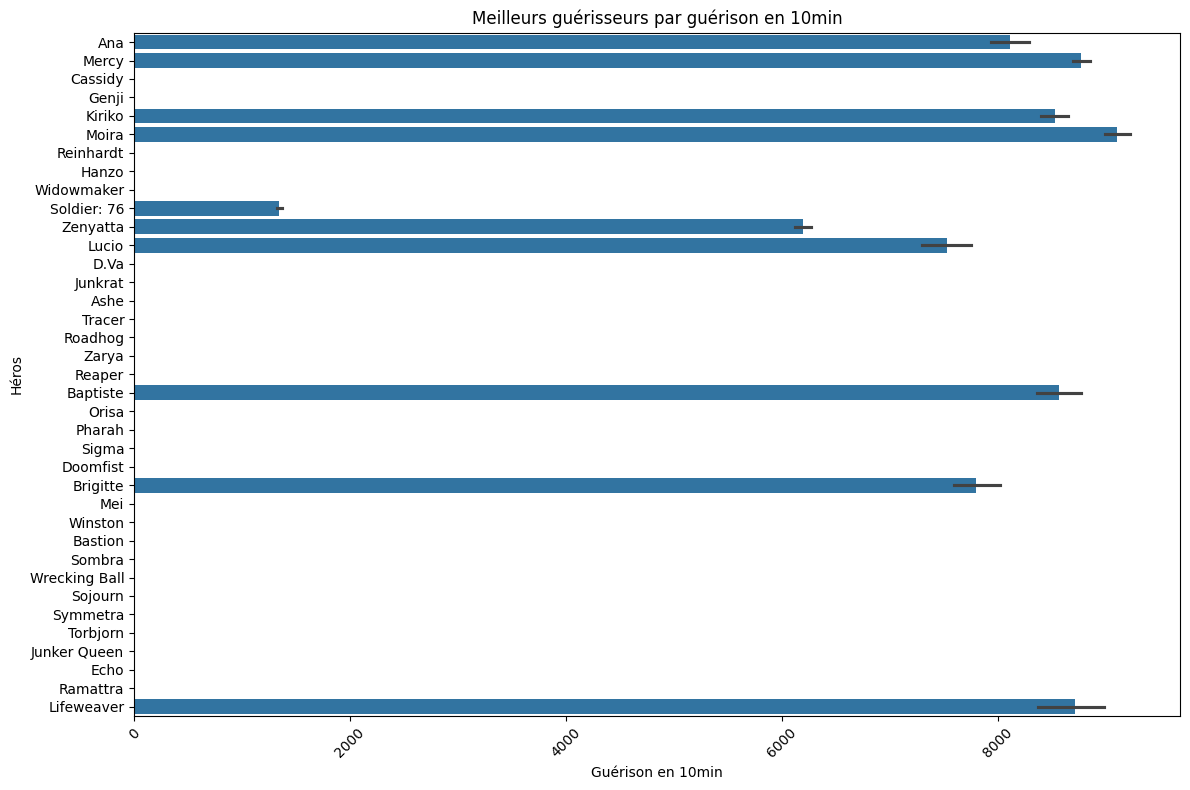

In [9]:
Graph_Best_Healers()

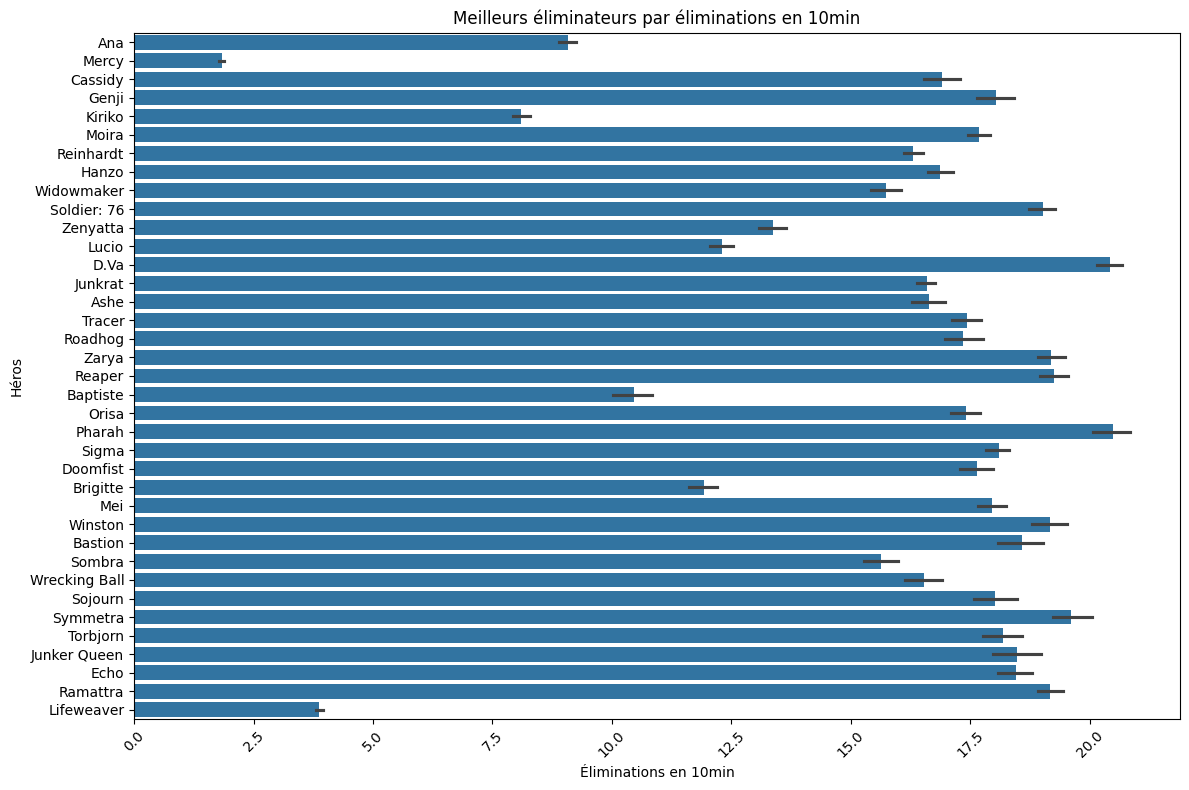

In [10]:
Graph_Best_Eliminators()